### Iniciando as biblioteca

In [1]:
# importando os modulos principais

%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path

#from datetime import date, datetime
import matplotlib.pyplot as plt
#import os
import seaborn as sns
#import re

### Carregando os dataframes de usuários, eventos e eventos por usuário

Esses dataframes foram criados a partir da extração dos dados Json do Flurry.

#### Dataframe: Users
Contém informações sobre todos os usuários que já tiveram eventos registrados no Flurry.
A observação é o userID e as features extraídas do Json foram: o principal país (CountryISO) de onde usuário usou o App e o tipo de celular usado (deviceModel).

<img src="../imagens/dataframe-users.png">

#### Dataframe: Events
Contém informações sobre todos os eventos já registrados no Flurry.
A observação é o nome do evento e as features extraídas do Flurry foram: a primeira data de ocorrência do evento (firstOccurrence), a última data em que um evento foi registrado (lastOccurrence), o intervalo em dias entre essas duas data e os meses do ano desde o lançamento do projeto. Em cada coluna é contabilizado quantos eventos foram registrados.
Para fazer: contabilizar quantos usuários únicos usaram o evento.

<img src="../imagens/dataframe-events.png">


#### Dataframe: Events Per Users
Contém informação sobre todos os eventos registrados no Flurry.
A observação é o conjunto usuário + dia ativo, ou (userId, eventDate).
Temos como features a quantidade de ocorrência (variável continua) para todos os eventos já registrados na plataforma

<img src="../imagens/dataframe-events-per-user.png">

In [2]:
# Define as variáveis com o Path e os nomes dos arquivos atualizados da última extração
path_csv = Path('/home/wesley/Github/ribon-parquet')
csv_eventFile = 'ribon_events_per_user_2020-04-12.csv'
csv_usersFile = 'ribon_users_2020-04-12.csv'
csv_events = 'ribon_events_2020-04-12.csv'

In [ ]:
%%time
# Carrega dataframe de eventos
events_per_user = pd.read_csv(path_csv/csv_eventFile, parse_dates=['eventDate'])
events_per_user.sort_values('eventDate', inplace=True)
print(events_per_user.shape)
events_per_user.info(),
events_per_user.head()

In [ ]:
# Carrega dataframe de users
#users = pd.read_csv(path_csv/csv_usersFile, parse_dates=['firstAccess', 'lastAccess'])
users = pd.read_csv(path_csv/csv_usersFile)
print(users.shape)
users.info(),
users.head()

In [ ]:
# carregando o data set de eventos
events = pd.read_csv(path_csv/csv_events, parse_dates=['firstOccurrence', 'lastOccurrence'])
print(events.shape)
events.info(),
events.head()

In [7]:
# Validando se está igual o número de usuários no dataframe de eventos e o de usuários
events_per_user.userId.nunique() == users.shape[0], events_per_user.userId.nunique(), users.shape[0]

(True, 207287, 207287)

In [8]:
# unificando os eventos de doação em uma única coluna
#events_per_user['donation'] = events_per_user['donate'] + events_per_user['Doou']

events_per_user['donation'] = events_per_user[['donate','Doou']].sum(axis=1)

events_per_user[['donation', 'donate', 'Doou']].sample(5)

,donation,donate,Doou
782653,0.0,NaN,NaN
1206365,2.0,NaN,2.0
3221825,0.0,NaN,NaN
359567,0.0,NaN,NaN
1160246,0.0,NaN,NaN


In [9]:
events_per_user.drop(['donate','Doou'], axis=1, inplace=True)

In [10]:
# definindo duas matrizes uma com as colunas que são de eventos e a outra que não são
NO_EVENTS = ['userId', 'eventDate']
EVENTS = [c for c in events_per_user.columns if c not in NO_EVENTS]
len(EVENTS)

196

In [22]:
df = events_per_user[NO_EVENTS]

In [32]:
df['month_event'] = df.eventDate.dt.strftime('%Y-%m')

/home/wesley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
df.shape[0]

3744464

In [38]:
df[['userId', 'month_event']].drop_duplicates().shape[0]

590353

In [74]:
df = df[['userId', 'month_event']].drop_duplicates()

In [178]:
df

,userId,month_event,userRibonAge
0,1111,2017-08,0
1,123,2017-10,0
2,6,2017-10,0
3,7,2017-10,0
6,4,2017-10,0
...,...,...,...
3740472,141787,2020-04,305
3740426,139642,2020-04,305
3740421,139408,2020-04,305
3740415,139025,2020-04,305


In [201]:
df[['userId','month_event']].groupby('month_event').count()

,userId
month_event,
2017-08,1
2017-10,354
2017-11,419
2017-12,678
2018-01,820
2018-02,548
2018-03,587
2018-04,1934
2018-05,4750


In [160]:
def funcDaysUsingPlat(r):
    month = pd.Timestamp(r['month_event'])
    user=r['userId']
    cohort=pd.Timestamp(users.loc[users.userId==user, 'firstAccess'].iloc[0].strftime('%Y-%m'))
    return (month - cohort).days

In [177]:
%%time
df['userRibonAge'] = df.apply(funcDaysUsingPlat, axis=1)

CPU times: user 4min 42s, sys: 39.7 ms, total: 4min 42s
Wall time: 4min 42s


In [179]:
df.head()

,userId,month_event,userRibonAge
0,1111,2017-08,0
1,123,2017-10,0
2,6,2017-10,0
3,7,2017-10,0
6,4,2017-10,0


In [227]:
df['userRibonAgeLabel'] = pd.cut(df.userRibonAge,bins=[-1,20,40,100,200,9999],
                                 labels=['ThisMonth','LastMonth', 'ThisQuarter','ThisSemester','Older'])

In [228]:
df.head()

,userId,month_event,userRibonAge,userRibonAgeLabel
0,1111,2017-08,0,ThisMonth
1,123,2017-10,0,ThisMonth
2,6,2017-10,0,ThisMonth
3,7,2017-10,0,ThisMonth
6,4,2017-10,0,ThisMonth


In [229]:
df1 = df[['month_event', 'userRibonAgeLabel', 'userRibonAge']].groupby(['month_event', 'userRibonAgeLabel']).size().reset_index()
df1.columns = ['month_event', 'userRibonAgeLabel', 'count']
df1 = df1.pivot(index='month_event', columns='userRibonAgeLabel', values='count')
df1.head()

userRibonAgeLabel,ThisMonth,LastMonth,ThisQuarter,ThisSemester,Older
month_event,,,,,
2017-08,1,0,0,0,0
2017-10,354,0,0,0,0
2017-11,156,263,0,0,0
2017-12,360,102,216,0,0
2018-01,369,210,240,1,0


In [239]:
df1

userRibonAgeLabel,ThisMonth,LastMonth,ThisQuarter,ThisSemester,Older
month_event,,,,,
2017-08,1,0,0,0,0
2017-10,354,0,0,0,0
2017-11,156,263,0,0,0
2017-12,360,102,216,0,0
2018-01,369,210,240,1,0
2018-02,109,171,165,103,0
2018-03,176,45,215,150,1
2018-04,1436,111,147,239,1
2018-05,3304,1002,131,209,104


In [262]:
df1.to_csv('months_events.csv')

In [230]:
df1[1:].sum(axis=1)

month_event
2017-10      354
2017-11      419
2017-12      678
2018-01      820
2018-02      548
2018-03      587
2018-04     1934
2018-05     4750
2018-06     5138
2018-07     5459
2018-08     6062
2018-09     8488
2018-10     8828
2018-11     8856
2018-12     8939
2019-01    14387
2019-02    14321
2019-03    15352
2019-04    24333
2019-05    68989
2019-06    42520
2019-07    42952
2019-08    50860
2019-09    40656
2019-10    45542
2019-11    34982
2019-12    31031
2020-01    27234
2020-02    27483
2020-03    27797
2020-04    20053
dtype: int64

In [259]:
df1[1:-1].index

Index(['2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
       '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
       '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
       '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
       '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03'],
      dtype='object', name='month_event')

In [260]:
df2 = df1[1:-1]

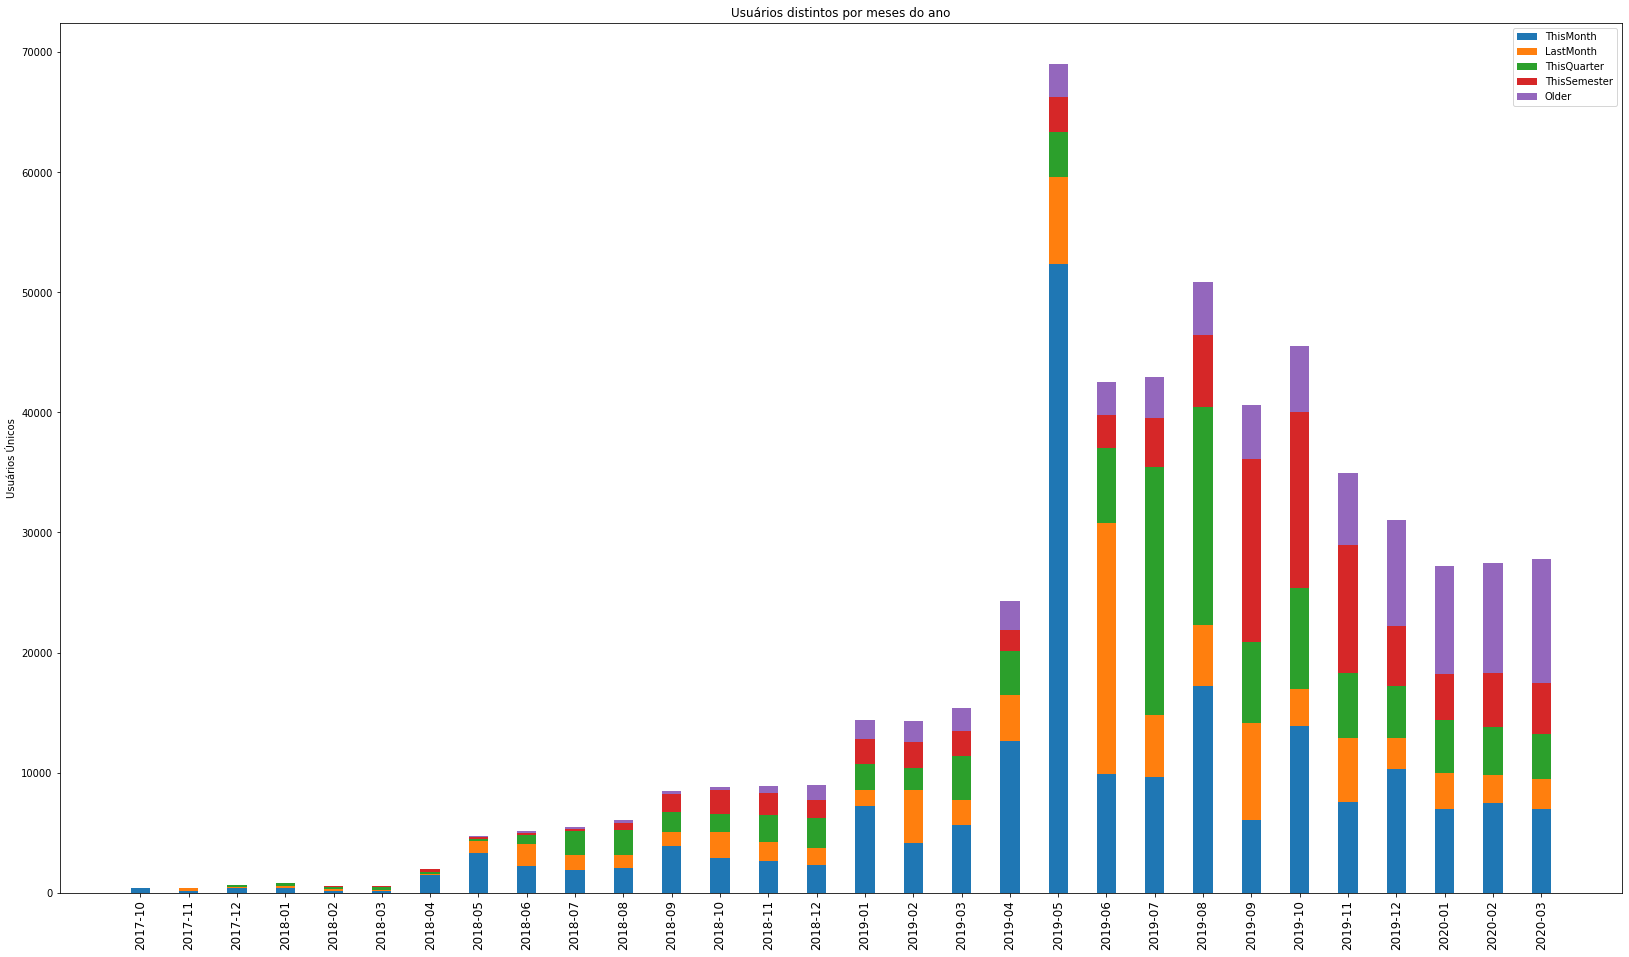

In [261]:
plt.figure(figsize=(28, 16))

ThisMonth = df2.ThisMonth.to_numpy()
LastMonth = df2.LastMonth.to_numpy()
ThisQuarter = df2.ThisQuarter.to_numpy()
ThisSemester = df2.ThisSemester.to_numpy()
Older = df2.Older.to_numpy()

ind = df2.index

width = 0.4      # the width of the bars: can also be len(x) sequence


p1 = plt.bar(ind, ThisMonth, width)
p2 = plt.bar(ind, LastMonth, width, bottom=ThisMonth)
p3 = plt.bar(ind, ThisQuarter, width, bottom=ThisMonth + LastMonth)
p4 = plt.bar(ind, ThisSemester, width, bottom=ThisMonth + LastMonth + ThisQuarter)
p5 = plt.bar(ind, Older, width, bottom=ThisMonth + LastMonth + ThisQuarter + ThisSemester)

# p1 = plt.bar(ind, ThisMonth, width)
# p2 = plt.bar(ind, LastMonth, width, bottom=ThisMonth)
# p3 = plt.bar(ind, ThisQuarter, width, bottom=LastMonth + ThisMonth)
# p4 = plt.bar(ind, ThisSemester, width, bottom=ThisQuarter + LastMonth + ThisMonth)
# p5 = plt.bar(ind, Older, width, bottom=ThisSemester + ThisQuarter + LastMonth + ThisMonth)

plt.ylabel('Usuários Únicos')
plt.title('Usuários distintos por meses do ano')
plt.xticks(ind, fontsize=12, rotation=90)
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('ThisMonth','LastMonth','ThisQuarter','ThisSemester','Older'))

plt.show()

In [281]:
users['lastDayAccess'] = (lastDay - users.lastAccess).dt.days
users.head()

,userId,deviceModel,countryISO,firstAccess,lastAccess,lastDayAccess
0,1,Moto G (5S) Plus,BR,2017-11-07,2020-03-22,21
1,2,Galaxy Note8,BR,2017-10-05,2020-03-24,19
2,8,Galaxy S10,BR,2017-10-11,2020-03-31,12
3,9,Galaxy S8,BR,2017-10-04,2020-04-09,3
4,15,Galaxy S8+,BR,2017-10-09,2020-04-03,9


In [283]:
users['lastDayLabel'] = pd.cut(users.lastDayAccess,bins=[-1,30,90,120,150,9999],
                               labels=['Last30Days','Last60Days', 'Last90Days','Last120Days','Inactive'])
users.head()

,userId,deviceModel,countryISO,firstAccess,lastAccess,lastDayAccess,lastDayLabel
0,1,Moto G (5S) Plus,BR,2017-11-07,2020-03-22,21,Last30Days
1,2,Galaxy Note8,BR,2017-10-05,2020-03-24,19,Last30Days
2,8,Galaxy S10,BR,2017-10-11,2020-03-31,12,Last30Days
3,9,Galaxy S8,BR,2017-10-04,2020-04-09,3,Last30Days
4,15,Galaxy S8+,BR,2017-10-09,2020-04-03,9,Last30Days


In [286]:
users['cohort'] = users.firstAccess.map(lambda x: x.strftime('%Y-%m'))
users.sample(5)

,userId,deviceModel,countryISO,firstAccess,lastAccess,lastDayAccess,lastDayLabel,cohort
199534,88255,Moto G Plus (5th Gen),BR,2019-05-02,2019-05-06,342,Inactive,2019-05
35517,262709,Moto E (5),BR,2020-04-03,2020-04-08,4,Last30Days,2020-04
97188,170684,Galaxy J8,BR,2019-08-23,2019-09-28,197,Inactive,2019-08
2313,37856,Galaxy S8,BR,2019-04-07,2020-04-07,5,Last30Days,2019-04
197452,85468,Galaxy J5 LTE,BR,2019-05-01,2019-05-02,346,Inactive,2019-05


In [288]:
dfu = users[['userId', 'cohort', 'lastDayLabel']].groupby(['cohort', 'lastDayLabel']).size().reset_index()
dfu.columns = ['cohort', 'lastDayLabel', 'count']
dfu = dfu.pivot(index='cohort', columns='lastDayLabel', values='count')
dfu

lastDayLabel,Last30Days,Last60Days,Last90Days,Last120Days,Inactive
cohort,,,,,
2017-08,0,0,0,0,1
2017-10,44,11,2,6,291
2017-11,14,4,1,0,137
2017-12,15,3,5,0,337
2018-01,20,5,1,5,338
2018-02,3,1,2,0,103
2018-03,12,4,0,1,159
2018-04,102,38,15,27,1254
2018-05,215,62,30,66,2931


In [289]:
dfu[1:].sum(axis=1)

cohort
2017-10      354
2017-11      156
2017-12      360
2018-01      369
2018-02      109
2018-03      176
2018-04     1436
2018-05     3304
2018-06     2237
2018-07     1897
2018-08     2076
2018-09     3921
2018-10     2896
2018-11     2669
2018-12     2271
2019-01     7229
2019-02     4103
2019-03     5627
2019-04    12671
2019-05    52347
2019-06     9866
2019-07     9593
2019-08    17181
2019-09     6038
2019-10    13879
2019-11     7593
2019-12    10318
2020-01     6973
2020-02     7439
2020-03     6956
2020-04     5242
dtype: int64

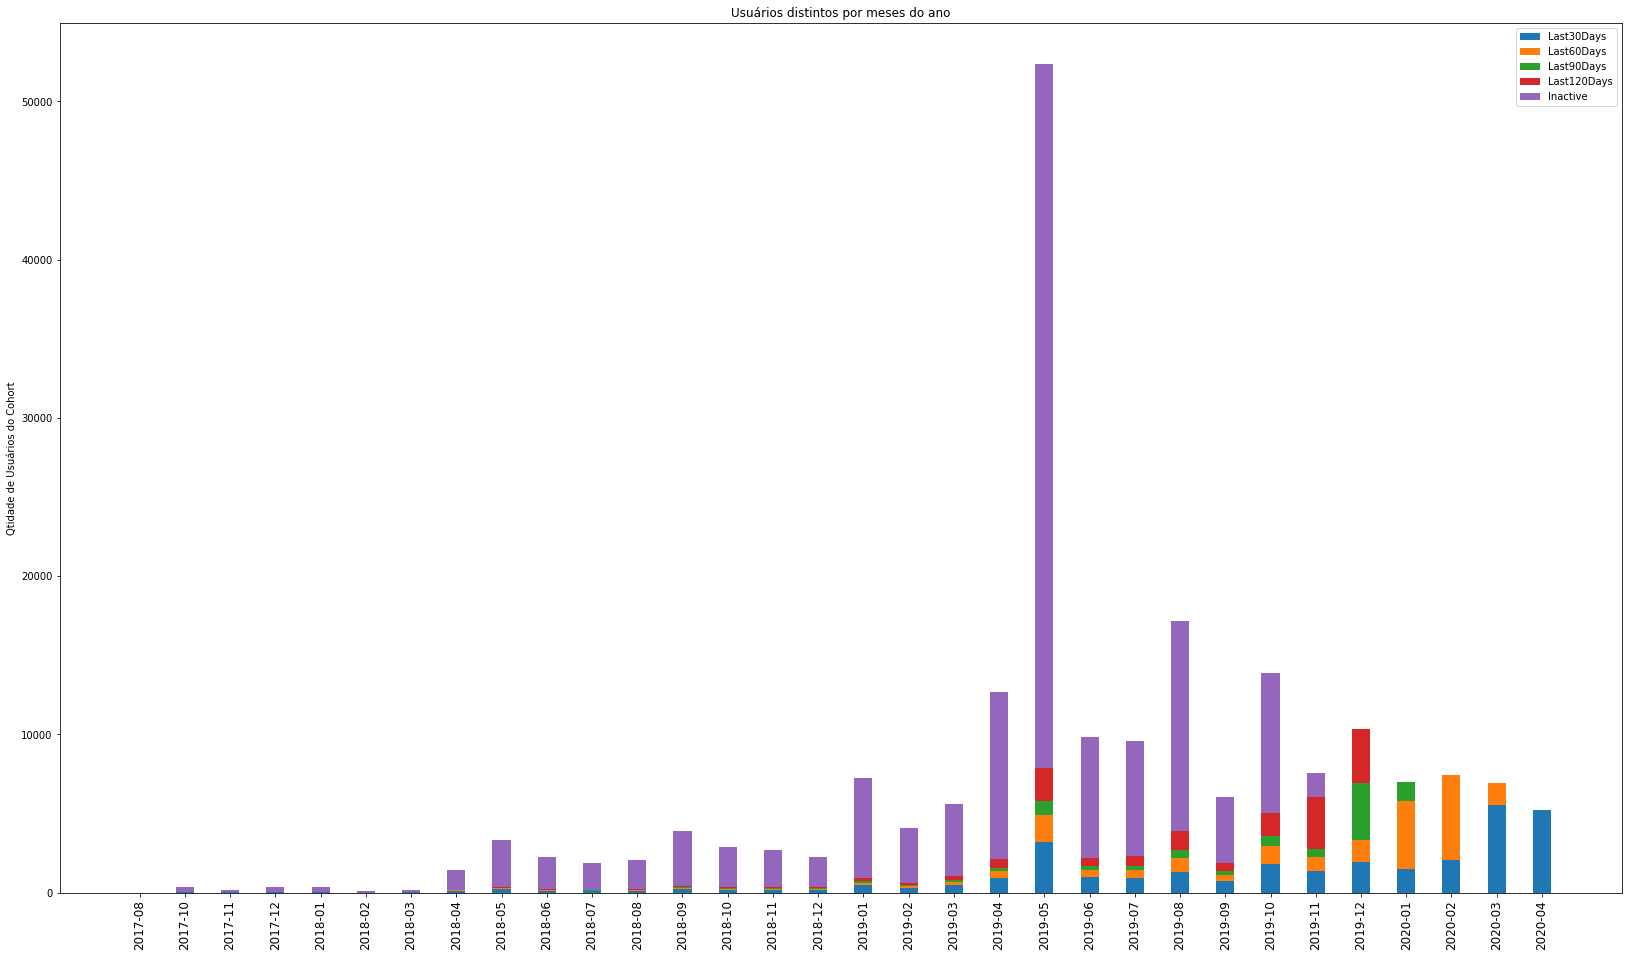

In [300]:
plt.figure(figsize=(28, 16))

Last30Days  = dfu.Last30Days.to_numpy()
Last60Days  = dfu.Last60Days.to_numpy()
Last90Days  = dfu.Last90Days.to_numpy()
Last120Days = dfu.Last120Days.to_numpy()
Inactive    = dfu.Inactive.to_numpy()

ind = dfu.index

width = 0.4      # the width of the bars: can also be len(x) sequence


# p1 = plt.bar(ind, Inactive,    width)
# p2 = plt.bar(ind, Last120Days, width, bottom=Inactive)
# p3 = plt.bar(ind, Last90Days,  width, bottom=Inactive + Last120Days)
# p4 = plt.bar(ind, Last60Days,  width, bottom=Inactive + Last120Days + Last90Days)
# p5 = plt.bar(ind, Last30Days,  width, bottom=Inactive + Last120Days + Last90Days + Last60Days)

p1 = plt.bar(ind, Last30Days,  width)
p2 = plt.bar(ind, Last60Days,  width, bottom=Last30Days)
p3 = plt.bar(ind, Last90Days,  width, bottom=Last30Days + Last60Days)
p4 = plt.bar(ind, Last120Days, width, bottom=Last30Days + Last60Days + Last90Days)
p5 = plt.bar(ind, Inactive,    width, bottom=Last30Days + Last60Days + Last90Days + Last120Days)


plt.ylabel('Qtidade de Usuários do Cohort')
plt.title('Usuários distintos por meses do ano')
plt.xticks(ind, fontsize=12, rotation=90)
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Last30Days','Last60Days','Last90Days','Last120Days','Inactive'))

plt.show()

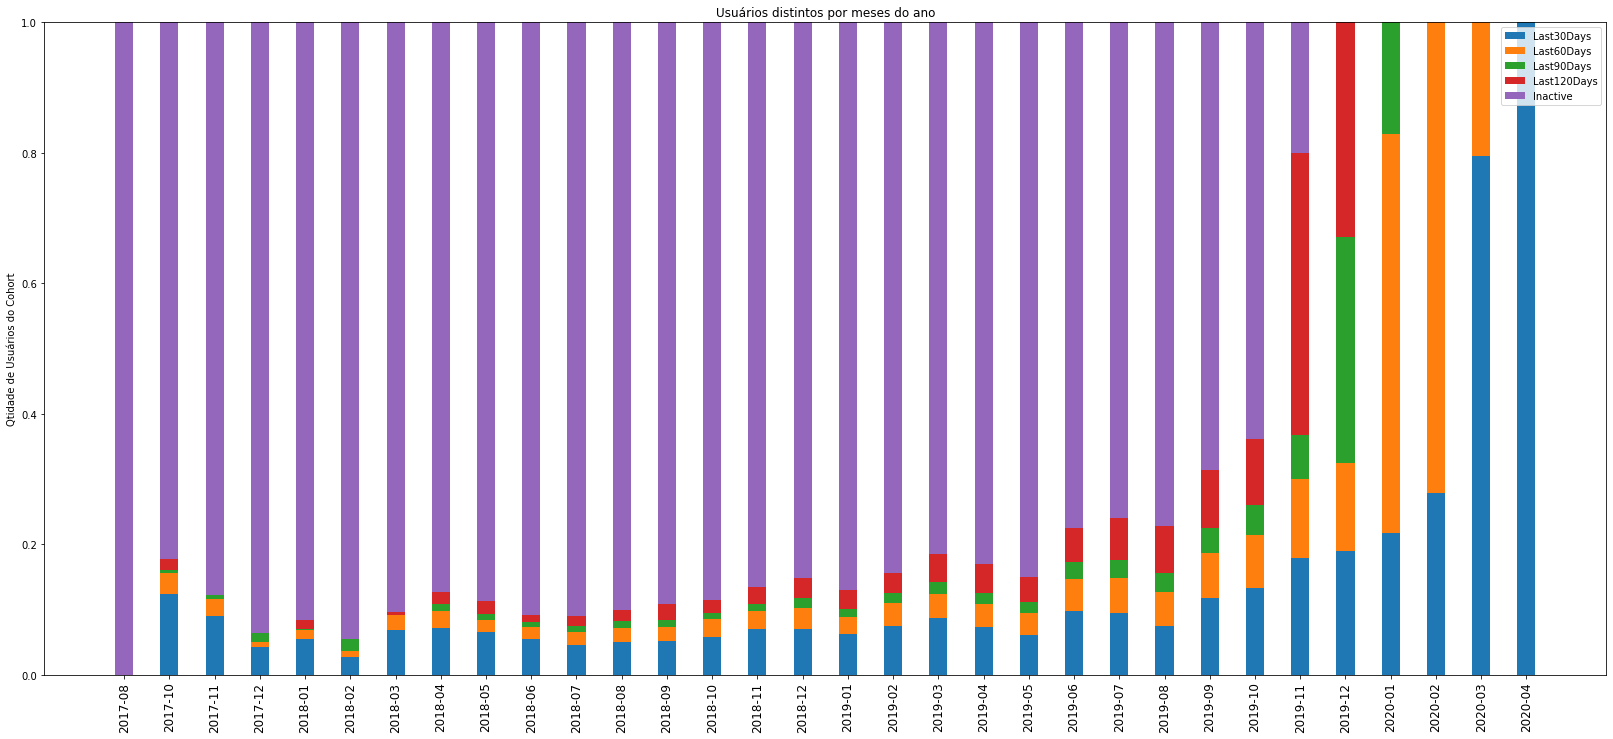

In [309]:
#dfu.Inactive/dfu.sum(axis=1).to_numpy()

plt.figure(figsize=(28, 12))

Last30Days  = (dfu.Last30Days  / dfu.sum(axis=1)).to_numpy()
Last60Days  = (dfu.Last60Days  / dfu.sum(axis=1)).to_numpy()
Last90Days  = (dfu.Last90Days  / dfu.sum(axis=1)).to_numpy()
Last120Days = (dfu.Last120Days / dfu.sum(axis=1)).to_numpy()
Inactive    = (dfu.Inactive    / dfu.sum(axis=1)).to_numpy()

ind = dfu.index

width = 0.4      # the width of the bars: can also be len(x) sequence


# p1 = plt.bar(ind, Inactive,    width)
# p2 = plt.bar(ind, Last120Days, width, bottom=Inactive)
# p3 = plt.bar(ind, Last90Days,  width, bottom=Inactive + Last120Days)
# p4 = plt.bar(ind, Last60Days,  width, bottom=Inactive + Last120Days + Last90Days)
# p5 = plt.bar(ind, Last30Days,  width, bottom=Inactive + Last120Days + Last90Days + Last60Days)

p1 = plt.bar(ind, Last30Days,  width)
p2 = plt.bar(ind, Last60Days,  width, bottom=Last30Days)
p3 = plt.bar(ind, Last90Days,  width, bottom=Last30Days + Last60Days)
p4 = plt.bar(ind, Last120Days, width, bottom=Last30Days + Last60Days + Last90Days)
p5 = plt.bar(ind, Inactive,    width, bottom=Last30Days + Last60Days + Last90Days + Last120Days)


plt.ylabel('Qtidade de Usuários do Cohort')
plt.title('Usuários distintos por meses do ano')
plt.xticks(ind, fontsize=12, rotation=90)
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Last30Days','Last60Days','Last90Days','Last120Days','Inactive'))

plt.show()

### Feature Engineering

Para a modelagem de cluster vamos enriquecer o dataframe de users, estendendo o número de features.
Como o objetivo é clusterizar os usuários ativos, primeiro vamos definir uma premissa que atenda essa condição.
A premissa inicial é que os usuários extraem o valor de negócio da Ribon usam regularmente o apllicativo fazendo uma doação.
Vimos que mais de 200 mil usuários passaram pela plataforma desde o seu lançamento.

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxx

Gráfico de usuários entrantes na plataforma por mês
de preferencia com cor mostrando quais continuaram usando a plataforma mais de 120 dias, mais de 90 dias, mais de 60 dias, mais de 30 dias

Gráfico de usuários diferentes usando a plataforma por mês
usuários do mes em questão
usuários de meses anteriores 

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxx

O trabalho complementar a este, que está focado em identificar o churn de usuários, 


In [304]:
# verificando a data do último evento e definindo a data de corte para definir usuários ativos
days_AP = 120                                               # define quantos dias é o AP - Active Period
lastDay = events_per_user.eventDate.sort_values().iloc[-1]  # encontra a última data do dataframe de eeventos
beginActivePeriod = lastDay - pd.DateOffset(days_AP)        # define o dia em que inicia o AP
lastDay, beginActivePeriod

(Timestamp('2020-04-12 00:00:00'), Timestamp('2019-12-14 00:00:00'))

In [14]:
# teste de features para um usuário aleatório

a = users.sample().userId.values[0]
usersample=a
firstAccess = events_per_user[events_per_user.userId == a]['eventDate'].sort_values().iloc[0]
lastAccess = events_per_user[events_per_user.userId == a]['eventDate'].sort_values().iloc[-1]
activeDays = events_per_user[events_per_user.userId == a].shape[0]
calendarDays = (lastAccess - firstAccess + pd.DateOffset(1)).days
#calendarDays = calendarDays.days
donationTotal = events_per_user[events_per_user.userId == a]['donation'].sum()
averageEventActiveDay = donationTotal / activeDays
averageEventCalendarDay = donationTotal / calendarDays
print('User: ', a)
print('First Access: ', firstAccess)
print('Last Access: ', lastAccess)
print('Active Days :', activeDays)
print('Calendar Days:', calendarDays)
print('Donation Total: ', donationTotal)
print('Average event count per active day: ', averageEventActiveDay)
print('Average event count per calendar day: ', averageEventCalendarDay)
print()

donationAcitivityDaysAP = events_per_user[(events_per_user.eventDate >= beginActivePeriod) &\
                (events_per_user.userId==usersample) & (events_per_user.donation > 0)].shape[0]
print('Donation Acitivity Days in the Active Period: ', donationAcitivityDaysAP)

print()

cont = 0
limite = int(donationTotal/2)
soma = 0
for d in events_per_user[events_per_user.userId == a]['donation']:
    soma += d
    if soma > limite:
        break
    cont += 1

if (calendarDays > 0) & (donationTotal > 0):
    halfLifeDonation = events_per_user[events_per_user.userId == a]['eventDate'].reindex().iloc[cont]
    halfLifeDonation = halfLifeDonation - firstAccess + pd.DateOffset(1)
    halfLifeDonation = halfLifeDonation.days
else:
    halfLifeDonation = 0
print('Total donation event half-life - calendar day: ', halfLifeDonation)

if activeDays % 2 == 0:
    halfLifeActivityDays = int(activeDays / 2) - 1
else:
    halfLifeActivityDays = int(activeDays / 2)
halfLifeActivityDays = events_per_user[events_per_user.userId == a]['eventDate'].reindex().iloc[halfLifeActivityDays]
halfLifeActivityDays = halfLifeActivityDays - firstAccess + pd.DateOffset(1)
halfLifeActivityDays = halfLifeActivityDays.days
print('Half-life of user’s activity days: ', halfLifeActivityDays)

x = events_per_user[(events_per_user.userId == a) & (events_per_user.donation>0)][['eventDate','donation']].sort_values('eventDate')
x.shape[0],x
if x.shape[0] > 1:
    a = 0
    b = 0
    for i, e in reversed(list(enumerate(x.iterrows()))):
        if a == 0:
            a+= 1
            ultimaData = e[1][0]
            continue
        novaData = e[1][0]
        dif = ultimaData - novaData
        b += dif.days
        ultimaData = novaData
        
    print('Average days between an events previous occurrence: ',b/(x.shape[0]-1))

    print('Days since last and penultimate occurrence of the event:: ',
    (x.reindex().iloc[-1, 0] - x.reindex().iloc[-2, 0]).days)
else:
    print('Average days between an events previous occurrence: ',np.nan)
    print('Days since last and penultimate occurrence of the event:: ', np.nan)

User:  14591
First Access:  2018-08-22 00:00:00
Last Access:  2019-12-01 00:00:00
Active Days : 20
Calendar Days: 467
Donation Total:  84.0
Average event count per active day:  4.2
Average event count per calendar day:  0.17987152034261242

Donation Acitivity Days in the Active Period:  0

Total donation event half-life - calendar day:  416
Half-life of user’s activity days:  417
Average days between an events previous occurrence:  52.833333333333336
Days since last and penultimate occurrence of the event::  37


In [305]:
# funções para aplicar no dataset 'users' para definir a linha de corte

# encontra o primeiro acesso do usuário
def funcFirstAccess(u):
    return events_per_user[events_per_user.userId == u['userId']]['eventDate'].sort_values().iloc[0]

# encontra o último acesso do usuário
def funcLastAccess(u):
    return events_per_user[events_per_user.userId == u['userId']]['eventDate'].sort_values().iloc[-1]

In [43]:
# Aplica as funções para criar as features primeiro acesso, último acesso, total de doação
# Elas serão usadas para definir usuários ativos e inativos

# firstAccess - calcula o primeiro acesso dos usuários
%time users['firstAccess'] = users.apply(funcFirstAccess, axis=1)

# lastAccess - calcula o último acesso dos usuários
%time users['lastAccess'] = users.apply(funcLastAccess, axis=1)

CPU times: user 17min 19s, sys: 154 ms, total: 17min 19s
Wall time: 17min 20s
CPU times: user 17min 38s, sys: 174 ms, total: 17min 38s
Wall time: 17min 38s


In [306]:
# donationAP - calcula os dias ativos fazendo doação no período de corte (AP)
#              o usuário deve ter feito uma ou mais doações para contabilizar
def funcTotalDonationAP(u):
    return events_per_user[(events_per_user.eventDate >= beginActivePeriod) &\
                (events_per_user.userId==u['userId']) & (events_per_user.donation > 0)].shape[0]

In [307]:
# donationAP - calcula os dias ativos fazendo doação no período de corte (AP)

# verificando a data do último evento e definindo a data de corte para definir usuários ativos
days_AP = 120                                               # define quantos dias é o AP - Active Period
lastDay = events_per_user.eventDate.sort_values().iloc[-1]  # encontra a última data do dataframe de eeventos
beginActivePeriod = lastDay - pd.DateOffset(days_AP)        # define o dia em que inicia o AP

%time users['donationActivityDaysAP'] = users[users.lastAccess >= beginActivePeriod].\
apply(funcTotalDonationAP, axis=1)

CPU times: user 18min 59s, sys: 98.2 ms, total: 18min 59s
Wall time: 18min 59s


In [367]:
# verificando a data do último evento e definindo a data de corte para definir usuários ativos
days_AP = 90                                               # define quantos dias é o AP - Active Period
lastDay = events_per_user.eventDate.sort_values().iloc[-1]  # encontra a última data do dataframe de eeventos
beginActivePeriod = lastDay - pd.DateOffset(days_AP)        # define o dia em que inicia o AP

# donationAP - calcula os dias ativos fazendo doação no período de corte (AP)
%time users['donationActivityDaysAP90'] = users[users.lastAccess >= beginActivePeriod].\
apply(funcTotalDonationAP, axis=1)

CPU times: user 13min 56s, sys: 34.7 ms, total: 13min 56s
Wall time: 13min 56s


In [370]:
#estabelecendo o número de doações para definir o perfil do usuário ativo
n_donationDays = 1 # define o minimo de dias fazendo doacao durante o periodo de corte
sliceUsersAP = users.donationActivityDaysAP >= n_donationDays
sliceUsersAP90 = users.donationActivityDaysAP90 >= n_donationDays
users[sliceUsersAP].shape[0], users[sliceUsersAP90].shape[0]

(40634, 34689)

In [345]:
users[sliceUsersAP].donationActivityDaysAP.describe()

count    40634.000000
mean         8.528548
std         14.864081
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        121.000000
Name: donationActivityDaysAP, dtype: float64

In [371]:
users[sliceUsersAP90].donationActivityDaysAP90.describe()

count    34689.000000
mean         7.708207
std         12.394551
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max         91.000000
Name: donationActivityDaysAP90, dtype: float64

In [346]:
# Computing the ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n
    
    return x, y

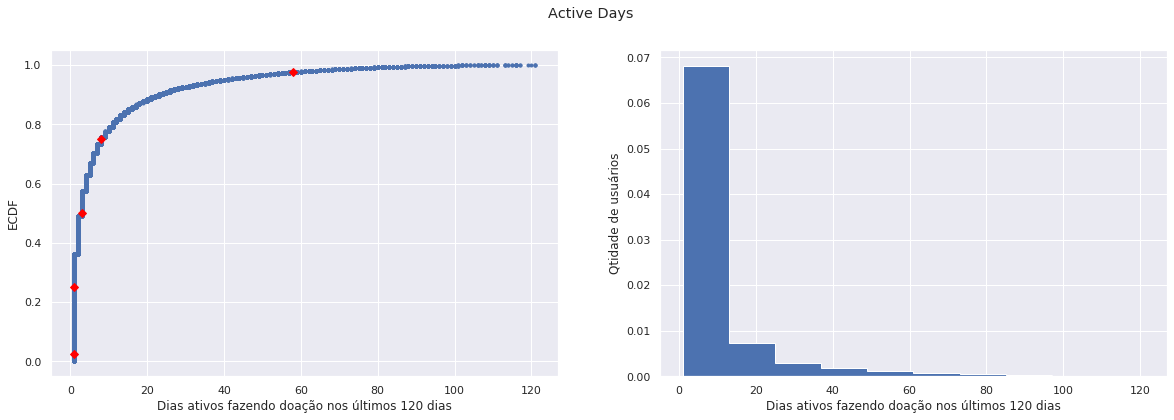

In [365]:
# Generate subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
_ = fig.suptitle('Active Days')

# Generate CDFs
x_ecdf, y_ecdf = ecdf(users[sliceUsersAP].donationActivityDaysAP)

# Plot CDFs
_ = ax1.plot(x_ecdf, y_ecdf, marker='.', linestyle='none')

# Specify array of percentiles: percentiles
percentiles = [2.5, 25, 50, 75, 97.5]
# Compute percentiles: ptiles_vers
ptiles_vers = np.percentile(users[sliceUsersAP].donationActivityDaysAP, percentiles)

# Overlay percentiles as red diamonds.
ptiles = [x/100 for x in percentiles]
_ = ax1.plot(ptiles_vers, ptiles, marker='D', color='red', linestyle='none')

# Label axes
_ = ax1.set_xlabel('Dias ativos fazendo doação nos últimos 120 dias')
_ = ax1.set_ylabel('ECDF')

# Make the histogram
_ = ax2.hist(users[sliceUsersAP].donationActivityDaysAP, bins=10, density=True, histtype='stepfilled')


# Label axes
_ = ax2.set_xlabel('Dias ativos fazendo doação nos últimos 120 dias')
_ = ax2.set_ylabel('Qtidade de usuários')

# Show the plot
plt.show()

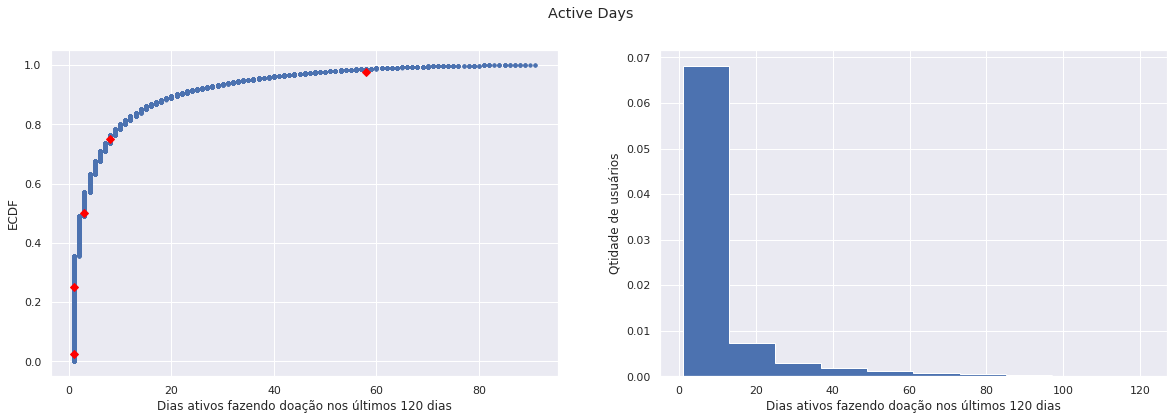

In [373]:
# Generate subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
_ = fig.suptitle('Active Days')

# Generate CDFs
x_ecdf, y_ecdf = ecdf(users[sliceUsersAP90].donationActivityDaysAP90)

# Plot CDFs
_ = ax1.plot(x_ecdf, y_ecdf, marker='.', linestyle='none')

# Specify array of percentiles: percentiles
percentiles = [2.5, 25, 50, 75, 97.5]
# Compute percentiles: ptiles_vers
ptiles_vers = np.percentile(users[sliceUsersAP].donationActivityDaysAP, percentiles)

# Overlay percentiles as red diamonds.
ptiles = [x/100 for x in percentiles]
_ = ax1.plot(ptiles_vers, ptiles, marker='D', color='red', linestyle='none')

# Label axes
_ = ax1.set_xlabel('Dias ativos fazendo doação nos últimos 90 dias')
_ = ax1.set_ylabel('ECDF')

# Make the histogram
_ = ax2.hist(users[sliceUsersAP].donationActivityDaysAP, bins=10, density=True, histtype='stepfilled')


# Label axes
_ = ax2.set_xlabel('Dias ativos fazendo doação nos últimos 90 dias')
_ = ax2.set_ylabel('Qtidade de usuários')

# Show the plot
plt.show()

In [319]:
users[sliceUsersAP].cohort.nunique()

31

In [374]:
users[sliceUsersAP90].cohort.nunique()

31

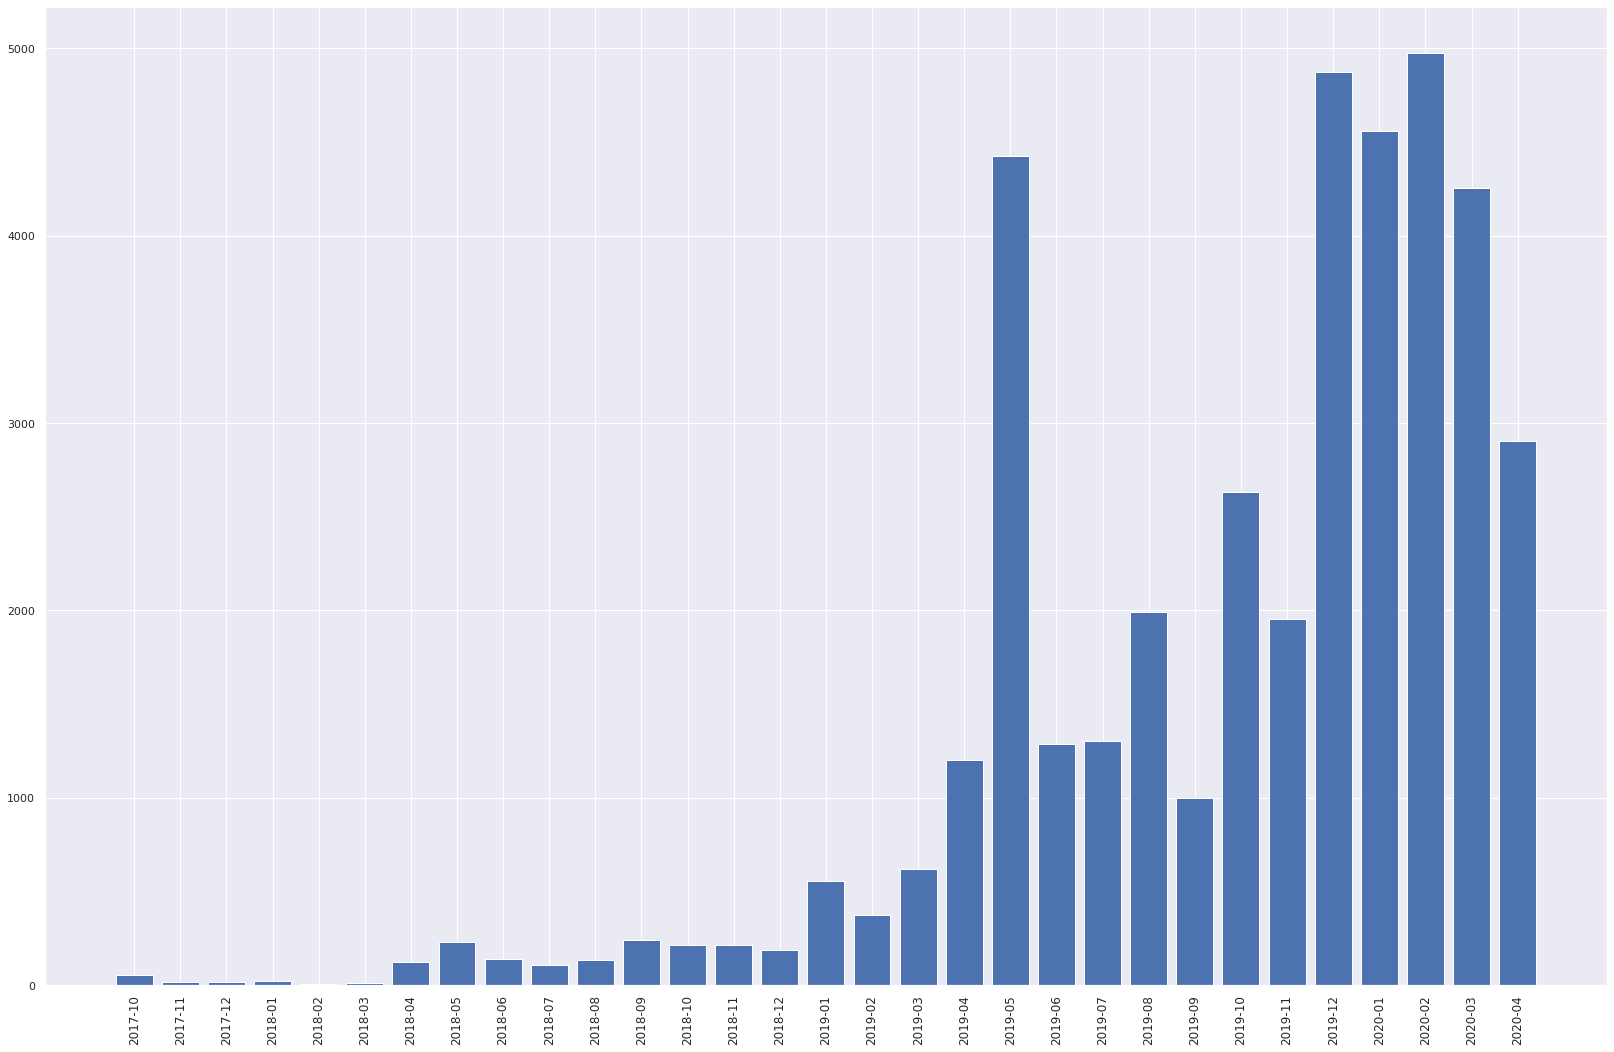

In [375]:
sns.set()
plt.figure(figsize=(28, 18))
plt.xticks(fontsize=12, rotation=90)
_ = plt.bar(users.loc[sliceUsersAP, ['cohort']].groupby('cohort').size()\
            .index, users.loc[sliceUsersAP, ['cohort']].groupby('cohort').size())

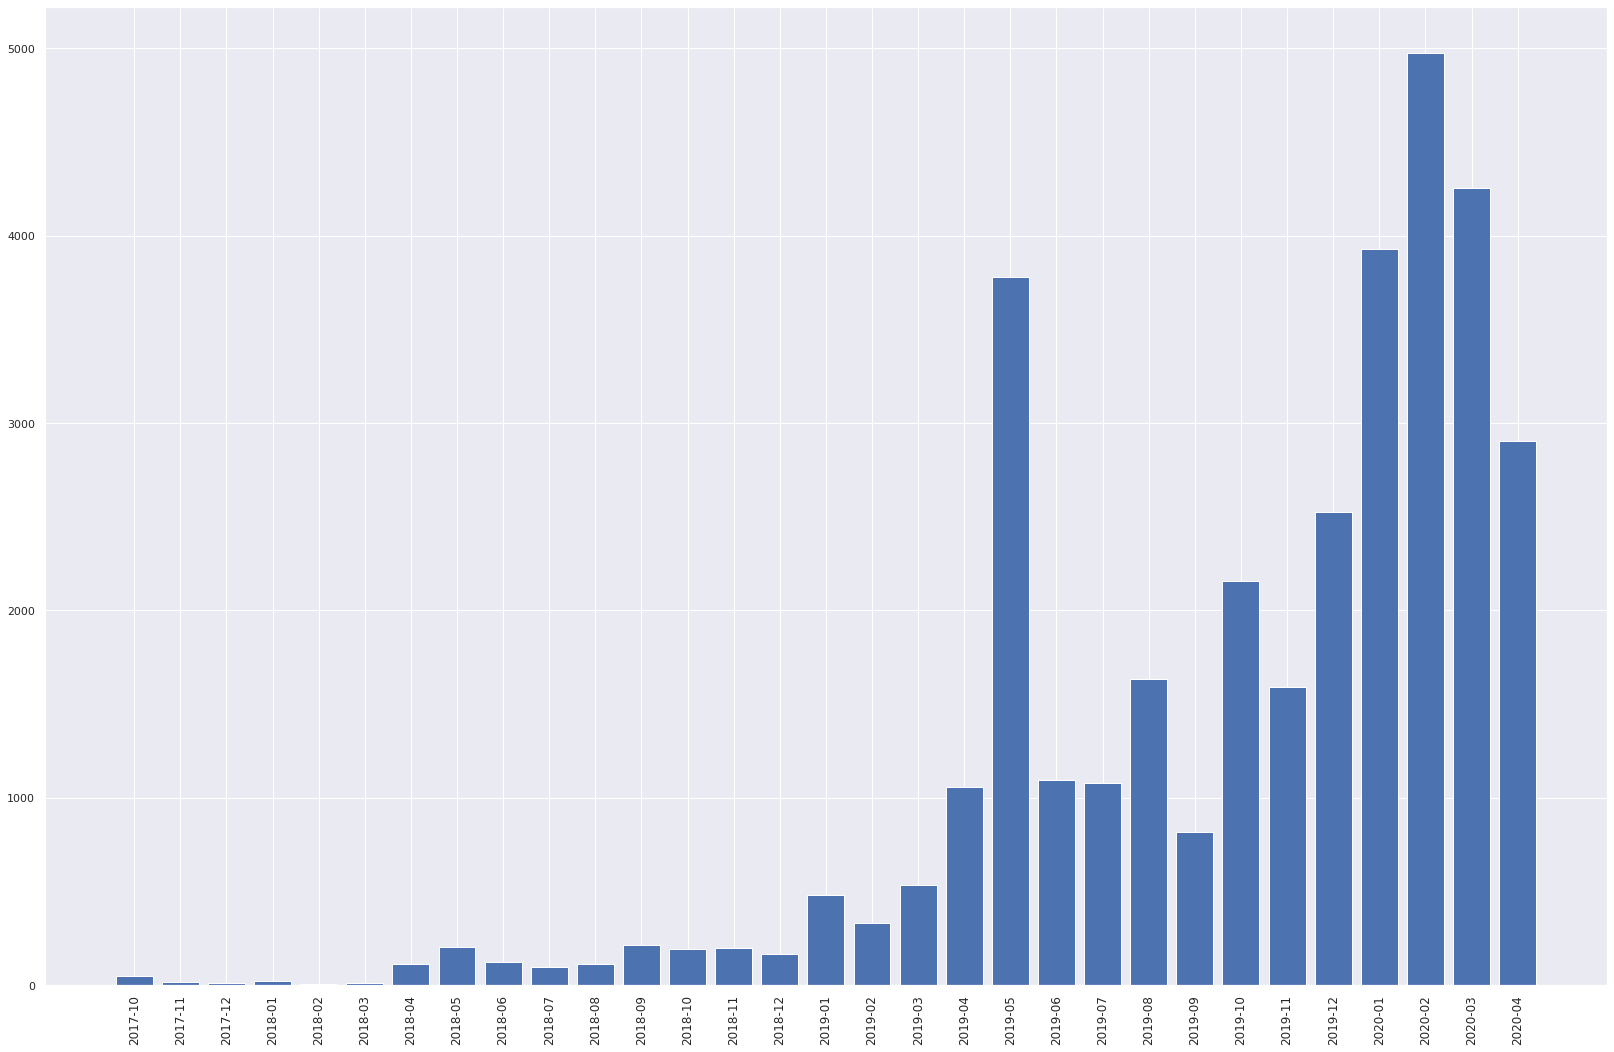

In [376]:
sns.set()
plt.figure(figsize=(28, 18))
plt.xticks(fontsize=12, rotation=90)
_ = plt.bar(users.loc[sliceUsersAP90, ['cohort']].groupby('cohort').size().\
            index, users.loc[sliceUsersAP90, ['cohort']].groupby('cohort').size())

In [377]:
users['donationAPLabel'] = pd.cut(users.donationActivityDaysAP,bins=[0,1,2,3,8,200],
                                  labels=['Doou1','Doou2', 'Doou3','Doou3_8','DoouMais8'])
users['donationAPLabel90'] = pd.cut(users.donationActivityDaysAP,bins=[0,1,2,3,8,200],
                                  labels=['Doou1','Doou2', 'Doou3','Doou3_8','DoouMais8'])
users.head()

,userId,deviceModel,countryISO,firstAccess,lastAccess,lastDayAccess,lastDayLabel,cohort,donationActivityDaysAP,donationAPLabel,donationActivityDaysAP90,donationAPLabel90
0,1,Moto G (5S) Plus,BR,2017-11-07,2020-03-22,21,Last30Days,2017-11,18.0,DoouMais8,12.0,DoouMais8
1,2,Galaxy Note8,BR,2017-10-05,2020-03-24,19,Last30Days,2017-10,3.0,Doou3,3.0,Doou3
2,8,Galaxy S10,BR,2017-10-11,2020-03-31,12,Last30Days,2017-10,4.0,Doou3_8,3.0,Doou3_8
3,9,Galaxy S8,BR,2017-10-04,2020-04-09,3,Last30Days,2017-10,13.0,DoouMais8,13.0,DoouMais8
4,15,Galaxy S8+,BR,2017-10-09,2020-04-03,9,Last30Days,2017-10,14.0,DoouMais8,12.0,DoouMais8


In [360]:
dfc = users.loc[sliceUsersAP, ['userId', 'cohort', 'donationAPLabel']].\
      groupby(['cohort', 'donationAPLabel']).size().reset_index()
dfc.columns = ['cohort', 'donationAPLabel', 'count']
dfc = dfc.pivot(index='cohort', columns='donationAPLabel', values='count')
dfc

donationAPLabel,Doou1,Doou2,Doou3,Doou3_8,DoouMais8
cohort,,,,,
2017-10,10,8,5,10,20
2017-11,0,6,2,3,6
2017-12,6,0,1,3,6
2018-01,7,1,3,5,8
2018-02,1,0,0,1,2
2018-03,4,0,1,3,5
2018-04,33,15,9,30,39
2018-05,58,41,18,40,73
2018-06,38,16,15,17,54


In [378]:
dfc90 = users.loc[sliceUsersAP90, ['userId', 'cohort', 'donationAPLabel90']].\
       groupby(['cohort', 'donationAPLabel90']).size().reset_index()
dfc90.columns = ['cohort', 'donationAPLabel90', 'count']
dfc90 = dfc90.pivot(index='cohort', columns='donationAPLabel90', values='count')
dfc90

donationAPLabel90,Doou1,Doou2,Doou3,Doou3_8,DoouMais8
cohort,,,,,
2017-10,7,8,5,9,20
2017-11,0,4,2,3,6
2017-12,4,0,1,3,6
2018-01,6,1,3,5,8
2018-02,1,0,0,1,2
2018-03,3,0,1,3,5
2018-04,25,13,9,29,39
2018-05,38,37,17,37,73
2018-06,25,15,14,17,54


In [380]:
dfc.sum(axis=1).sum(), dfc90.sum(axis=1).sum()

(40634, 34689)

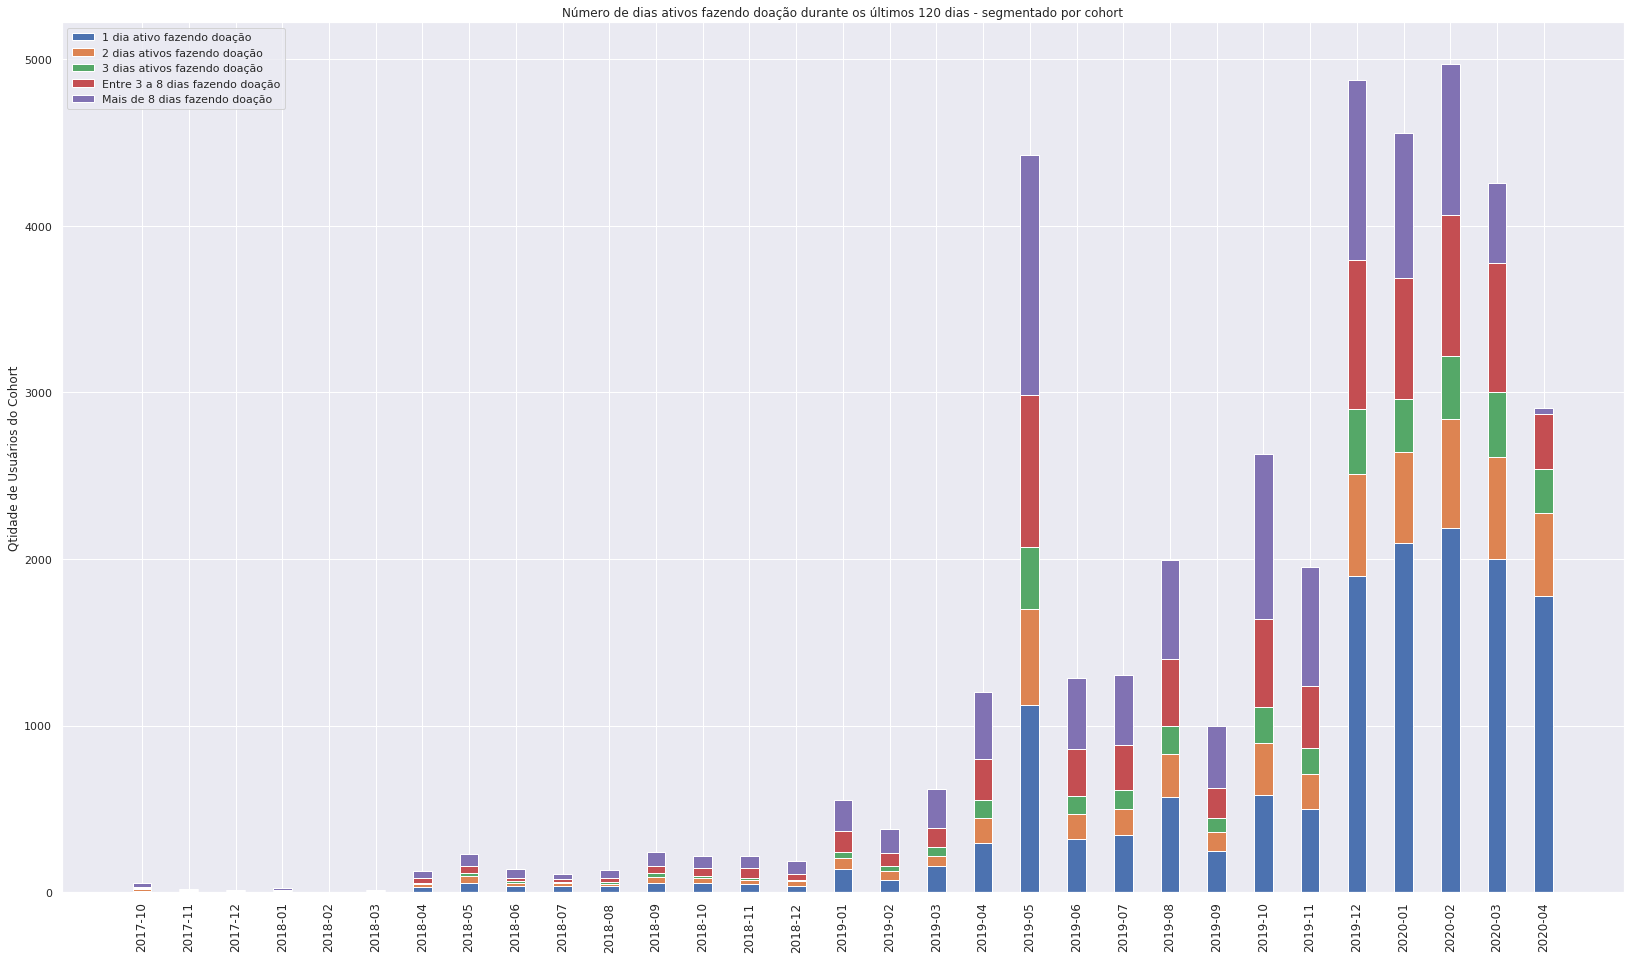

In [382]:
plt.figure(figsize=(28, 16))

Doou1     = dfc.Doou1.to_numpy()
Doou2     = dfc.Doou2.to_numpy()
Doou3     = dfc.Doou3.to_numpy()
Doou3_8   = dfc.Doou3_8.to_numpy()
DoouMais8 = dfc.DoouMais8.to_numpy()

ind = dfc.index

width = 0.4      # the width of the bars: can also be len(x) sequence


# p1 = plt.bar(ind, Inactive,    width)
# p2 = plt.bar(ind, Last120Days, width, bottom=Inactive)
# p3 = plt.bar(ind, Last90Days,  width, bottom=Inactive + Last120Days)
# p4 = plt.bar(ind, Last60Days,  width, bottom=Inactive + Last120Days + Last90Days)
# p5 = plt.bar(ind, Last30Days,  width, bottom=Inactive + Last120Days + Last90Days + Last60Days)

p1 = plt.bar(ind, Doou1,     width)
p2 = plt.bar(ind, Doou2,     width, bottom=Doou1)
p3 = plt.bar(ind, Doou3,     width, bottom=Doou1 + Doou2)
p4 = plt.bar(ind, Doou3_8,   width, bottom=Doou1 + Doou2 + Doou3)
p5 = plt.bar(ind, DoouMais8, width, bottom=Doou1 + Doou2 + Doou3 + Doou3_8)


plt.ylabel('Qtidade de Usuários do Cohort')
plt.title('Número de dias ativos fazendo doação durante os últimos 120 dias - segmentado por cohort')
plt.xticks(ind, fontsize=12, rotation=90)
# plt.yticks(np.arange(0, 81, 10))z
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('1 dia ativo fazendo doação','2 dias ativos fazendo doação',
                                                 '3 dias ativos fazendo doação','Entre 3 a 8 dias fazendo doação',
                                                 'Mais de 8 dias fazendo doação'))

plt.show()

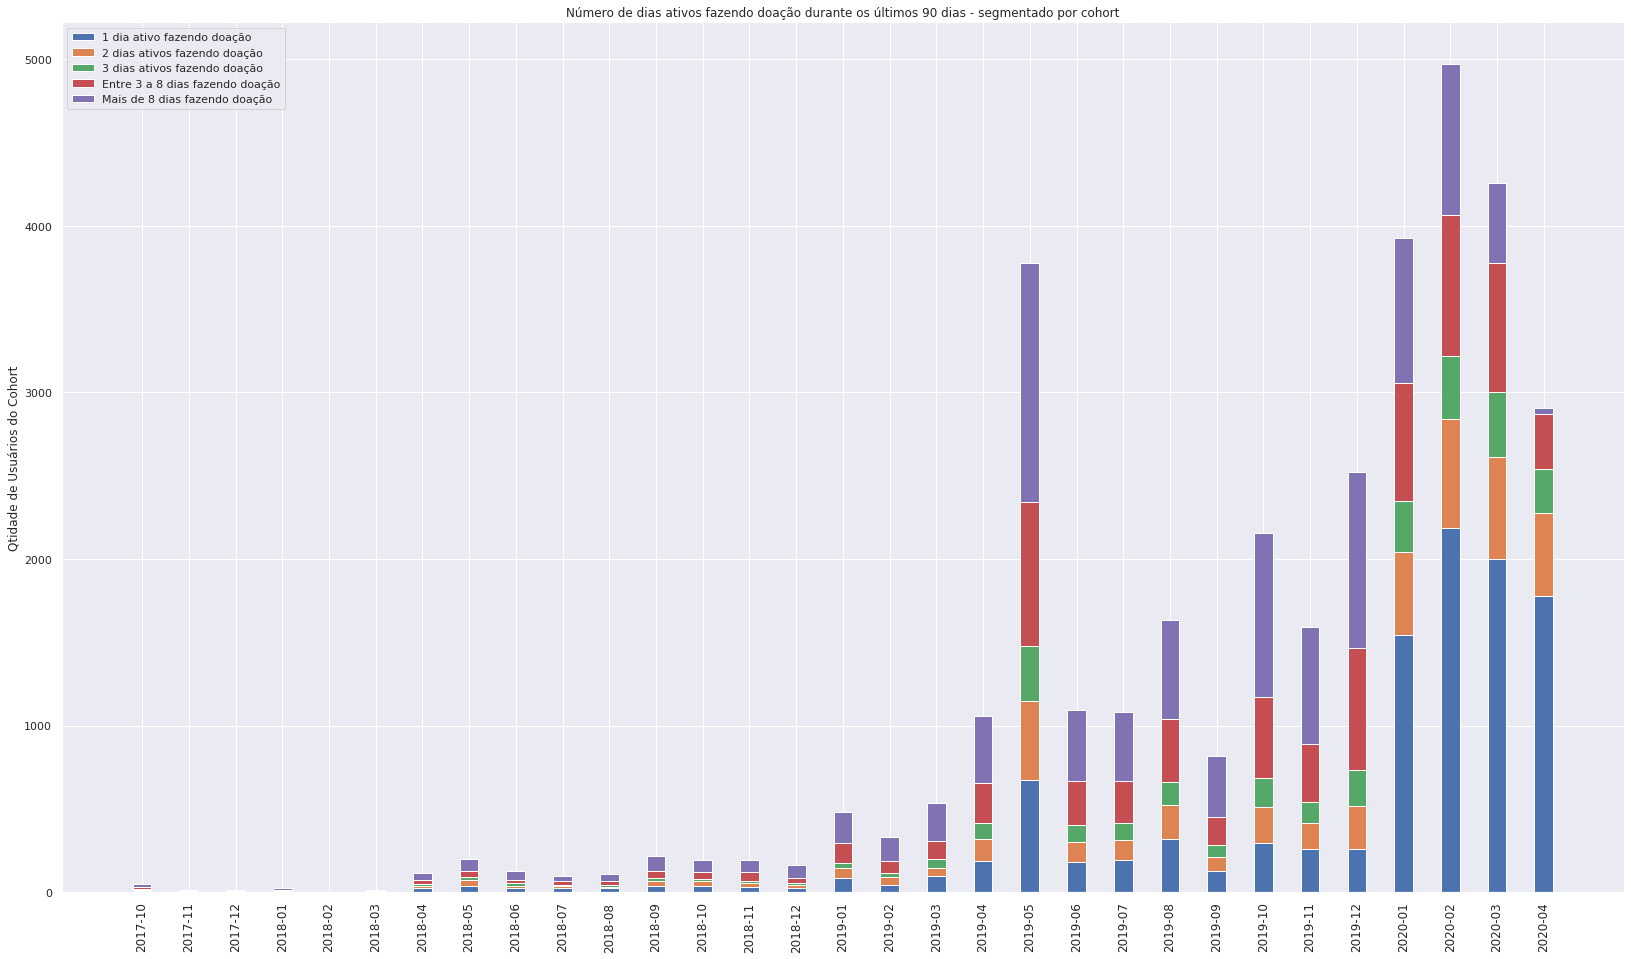

In [383]:
plt.figure(figsize=(28, 16))

Doou1     = dfc90.Doou1.to_numpy()
Doou2     = dfc90.Doou2.to_numpy()
Doou3     = dfc90.Doou3.to_numpy()
Doou3_8   = dfc90.Doou3_8.to_numpy()
DoouMais8 = dfc90.DoouMais8.to_numpy()

ind = dfc.index

width = 0.4      # the width of the bars: can also be len(x) sequence


# p1 = plt.bar(ind, Inactive,    width)
# p2 = plt.bar(ind, Last120Days, width, bottom=Inactive)
# p3 = plt.bar(ind, Last90Days,  width, bottom=Inactive + Last120Days)
# p4 = plt.bar(ind, Last60Days,  width, bottom=Inactive + Last120Days + Last90Days)
# p5 = plt.bar(ind, Last30Days,  width, bottom=Inactive + Last120Days + Last90Days + Last60Days)

p1 = plt.bar(ind, Doou1,     width)
p2 = plt.bar(ind, Doou2,     width, bottom=Doou1)
p3 = plt.bar(ind, Doou3,     width, bottom=Doou1 + Doou2)
p4 = plt.bar(ind, Doou3_8,   width, bottom=Doou1 + Doou2 + Doou3)
p5 = plt.bar(ind, DoouMais8, width, bottom=Doou1 + Doou2 + Doou3 + Doou3_8)


plt.ylabel('Qtidade de Usuários do Cohort')
plt.title('Número de dias ativos fazendo doação durante os últimos 90 dias - segmentado por cohort')
plt.xticks(ind, fontsize=12, rotation=90)
# plt.yticks(np.arange(0, 81, 10))z
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('1 dia ativo fazendo doação','2 dias ativos fazendo doação',
                                                 '3 dias ativos fazendo doação','Entre 3 a 8 dias fazendo doação',
                                                 'Mais de 8 dias fazendo doação'))

plt.show()

In [386]:
users[users.donationActivityDaysAP90 >= 1].shape

(34689, 12)

In [61]:
# criando a coluna que estabelece usuários ativos e inativos
users['active'] = False # define todos os usuários como ativo
users.loc[sliceUsersAP, 'active'] = True
users.active.sum()

25892

In [70]:
# Criando as funções do histórico completo do usuário

# calcula o número de dias entre o primeiro e último acesso do usuário
def funcCalendarDays(u):
    calendarDays = u['lastAccess'] - u['firstAccess'] + pd.DateOffset(1)
    return calendarDays.days

# encontra o número de dias que o usuário realizou algum evento no app
def funcActiveDays(u):
    return events_per_user[events_per_user.userId == u['userId']].shape[0]

# encontra a meia-vida dos dias ativos
# o número de dias calendários em que o usuário acessou a metade de seus dias ativos
def funcHalfLifeActivityDays(u):
    if u['activeDaysTWT'] % 2 == 0:
        halfLifeActivityDays = int(u['activeDaysTWT'] / 2) - 1
    else:
        halfLifeActivityDays = int(u['activeDaysTWT'] / 2)
    halfLifeActivityDays = list(events_per_user[events_per_user.userId == u['userId']]['eventDate'].sort_values())[halfLifeActivityDays]
    #halfLifeActivityDays = events_per_user[events_per_user.userId == u['userId']]['eventDate'].reindex().iloc[halfLifeActivityDays]
    halfLifeActivityDays = halfLifeActivityDays - u['firstAccess'] + pd.DateOffset(1)
    return halfLifeActivityDays.days

# calcula o número de eventos de doação realizados pelo usuário
def funcDonationTotal(u):
    return events_per_user[events_per_user.userId == u['userId']]['donation'].sum()

# calcula a meia-vida dos eventos de doação
# pega o número de dias calendários decorridos até o tempo em que o usuário fez metade dos eventos de doação
def funcHalfLifeDonation(u):        
    if (u['calendarDays'] > 0) & (u['donationTWT'] > 0):
        cont = 0
        limite = int(u['donationTWT']/2)
        soma = 0
        for d in events_per_user[events_per_user.userId == u['userId']]['donation']:
            soma += d
            if soma > limite:
                break
            cont += 1
        halfLifeDonation = events_per_user[events_per_user.userId == u['userId']]['eventDate'].reindex().iloc[cont]
        halfLifeDonation = halfLifeDonation - u['firstAccess'] + pd.DateOffset(1)
        return halfLifeDonation.days
    else:
        return 0

In [71]:
# Aplica as funções para criar as features número de dias calendário, dias ativos e meia vida de dias ativos

# calendarDays - calcula o número de dias calendários na plataforma
%time users['calendarDays'] = users[sliceUsersAP].apply(funcCalendarDays, axis=1)

# activeDays - calcula o número de dias ativos
%time users['activeDaysTWT'] = users[sliceUsersAP].apply(funcActiveDays, axis=1)

# halfLifeActivityDays - calcula o meia-vida de dias ativos
%time users['halfLifeActivityDaysTWT'] = users[sliceUsersAP].apply(funcHalfLifeActivityDays, axis=1)

# donationTotal - calcula o total de eventos de doação por usuário
%time users['donationTWT'] = users[sliceUsersAP].apply(funcDonationTotal, axis=1)

# halfLifeDonation - calcula a meia-vida de doações
%time users['halfLifeDonationTWT'] = users[sliceUsersAP].apply(funcHalfLifeDonation, axis=1)

CPU times: user 2.49 s, sys: 0 ns, total: 2.49 s
Wall time: 2.49 s
CPU times: user 1min 55s, sys: 0 ns, total: 1min 55s
Wall time: 1min 55s
CPU times: user 2min 13s, sys: 3.77 ms, total: 2min 13s
Wall time: 2min 13s
CPU times: user 1min 58s, sys: 3.84 ms, total: 1min 58s
Wall time: 1min 58s
CPU times: user 3min 59s, sys: 27.8 ms, total: 3min 59s
Wall time: 3min 59s


In [76]:
# averageEventActiveDay - calcula a média de doações por dias ativos
%time users['averageDonationEventActiveDayTWT'] = users['donationTWT'] / users['activeDaysTWT']

# averageEventCalendarDay - calcula a média de doações por dias calendários
%time users['averageDonationEventCalendarDayTWT'] = users['donationTWT'] / users['calendarDays']

CPU times: user 63.3 ms, sys: 4.02 ms, total: 67.3 ms
Wall time: 47.4 ms
CPU times: user 2.09 ms, sys: 13 µs, total: 2.1 ms
Wall time: 1.31 ms


/home/wesley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
users.head()

,userId,deviceModel,countryISO,firstAccess,lastAccess,donationActivityDaysAP,active,calendarDays,activeDaysTWT,halfLifeActivityDaysTWT,donationTWT,halfLifeDonationTWT,averageDonationEventActiveDayTWT,averageDonationEventCalendarDayTWT
0,1,Moto G (5S) Plus,BR,2017-11-07,2020-03-22,18.0,True,867.0,72.0,764.0,138.0,812.0,1.916667,0.159170
1,2,Galaxy Note8,BR,2017-10-05,2020-03-24,3.0,True,902.0,198.0,300.0,273.0,317.0,1.378788,0.302661
2,8,Galaxy S10,BR,2017-10-11,2020-03-31,4.0,True,903.0,79.0,294.0,90.0,163.0,1.139241,0.099668
3,9,Galaxy S8,BR,2017-10-04,2020-04-09,13.0,True,919.0,389.0,363.0,299.0,426.0,0.768638,0.325354
4,15,Galaxy S8+,BR,2017-10-09,2020-04-03,14.0,True,908.0,363.0,377.0,251.0,331.0,0.691460,0.276432


In [65]:
slice_EpU_AP = events_per_user.eventDate >= beginActivePeriod
events_per_user.shape[0],events_per_user[slice_EpU_AP].shape[0]

(3744464, 735805)

In [74]:
events_per_user = events_per_user[slice_EpU_AP]
users = users[sliceUsersAP]

In [75]:
events_per_user.shape, users.shape

((735805, 198), (25892, 12))

In [83]:
# encontra o número de dias que o usuário realizou algum evento no app durante o AP
def funcActiveDaysAP(u):
    return events_per_user[events_per_user.userId == u['userId']].shape[0]

# calcula o número de eventos de doação realizados pelo usuário durante o AP
def funcDonationAP(u):
    return events_per_user[events_per_user.userId == u['userId']]['donation'].sum()

# calcula a meia-vida dos eventos de doação
# pega o número de dias calendários decorridos até o tempo em que o usuário fez metade dos eventos de doação
def funcHalfLifeDonationAP(u):        
    cont = 0
    limite = int(u['donationAP']/2)
    soma = 0
    for d in events_per_user[events_per_user.userId == u['userId']]['donation']:
        soma += d
        cont += 1
        if soma > limite:
            break
    return cont


# identifica a média de dias entre os eventos de doação
# caso o usuário tenha feito um ou nenhum evento de doação, retorno NaN
def funcAverageDaysBetweenDonationEvents(u):
    x = events_per_user[(events_per_user.userId == u['userId']) & (events_per_user.donation>0)][['eventDate','donation']]
    if x.shape[0] > 1:
        a = 0
        b = 0
        for i, e in reversed(list(enumerate(x.iterrows()))):
            if a == 0:
                a+= 1
                ultimaData = e[1][0]
                continue
            novaData = e[1][0]
            dif = ultimaData - novaData
            b += dif.days
            ultimaData = novaData
        return b/(x.shape[0]-1)
    else:
        return np.nan

# identifica o número de dias entre o último e o penúltimo acesso
# caso o usuário tenha feito uma ou nenhum evento de doação, retorno NaN
def funcDaysSinceLastDonationEvent(u):
    x = events_per_user[(events_per_user.userId == u['userId']) & (events_per_user.donation>0)][['eventDate','donation']]
    if x.shape[0] > 1:
        return (x.reindex().iloc[-1, 0] - x.reindex().iloc[-2, 0]).days
    else:
        return np.nan

In [80]:
# activeDays - calcula o número de dias ativos
%time users['activeDaysAP'] = users.apply(funcActiveDaysAP, axis=1)

# eventos de doação

# donationTotal - calcula o total de eventos de doação por usuário
%time users['donationAP'] = users.apply(funcDonationAP, axis=1)

# averageEventActiveDay - calcula a média de doações por dias ativos
%time users['averageDonationEventActiveDayAP'] = users['donationAP'] / users['activeDaysAP']

# halfLifeDonation - calcula a meia-vida de doações
%time users['halfLifeDonationAP'] = users.apply(funcHalfLifeDonationAP, axis=1)

# Aplica as funções para criar as features relacionadas a doação
# número de doações totais, media de eventos de doação por dias ativos, media de eventos de doação por dias calendários
# meia-vida dos eventos de doação

# averageDaysBetweenDonationEvents - média de dias entre os eventos de doação
%time users['averageDaysBetweenDonationEvents'] = users.apply(funcAverageDaysBetweenDonationEvents, axis=1)

# daysSinceLastDonationEvent - número de dias entre a última e penultima doação
%time users['daysSinceLastDonationEvent'] = users.apply(funcDaysSinceLastDonationEvent, axis=1)

CPU times: user 31.6 s, sys: 23.9 ms, total: 31.6 s
Wall time: 31.6 s
CPU times: user 44.9 s, sys: 7.98 ms, total: 44.9 s
Wall time: 44.9 s
CPU times: user 34.4 s, sys: 7.98 ms, total: 34.4 s
Wall time: 34.4 s
CPU times: user 2.39 ms, sys: 0 ns, total: 2.39 ms
Wall time: 1.55 ms
CPU times: user 1min 10s, sys: 23.9 ms, total: 1min 10s
Wall time: 1min 10s
CPU times: user 1min 53s, sys: 7.97 ms, total: 1min 53s
Wall time: 1min 53s
CPU times: user 1min 38s, sys: 32 ms, total: 1min 38s
Wall time: 1min 38s


In [85]:
users.head()

,userId,deviceModel,countryISO,firstAccess,lastAccess,donationActivityDaysAP,active,calendarDays,activeDaysTWT,halfLifeActivityDaysTWT,...,halfLifeDonationTWT,averageDonationEventActiveDayTWT,averageDonationEventCalendarDayTWT,activeDaysAP,halfLifeActivityDaysAP,donationAP,averageDonationEventActiveDayAP,halfLifeDonationAP,averageDaysBetweenDonationEvents,daysSinceLastDonationEvent
0,1,Moto G (5S) Plus,BR,2017-11-07,2020-03-22,18.0,True,867.0,72.0,764.0,...,812.0,1.916667,0.159170,35,48,89.0,2.542857,23,5.117647,2
1,2,Galaxy Note8,BR,2017-10-05,2020-03-24,3.0,True,902.0,198.0,300.0,...,317.0,1.378788,0.302661,5,93,15.0,3.000000,3,32.500000,8
2,8,Galaxy S10,BR,2017-10-11,2020-03-31,4.0,True,903.0,79.0,294.0,...,163.0,1.139241,0.099668,6,60,12.0,2.000000,5,35.000000,33
3,9,Galaxy S8,BR,2017-10-04,2020-04-09,13.0,True,919.0,389.0,363.0,...,426.0,0.768638,0.325354,34,80,25.0,0.735294,20,6.916667,6
4,15,Galaxy S8+,BR,2017-10-09,2020-04-03,14.0,True,908.0,363.0,377.0,...,331.0,0.691460,0.276432,30,60,18.0,0.600000,12,8.307692,36


In [86]:
# definindo as funções que vão gerar features para os outros eventos.

# calcula o total de eventos e realizados pelo usuário u
# essa função será usada por todos os eventos
def funcEventTotal(u, e):
    return events_per_user[events_per_user.userId == u][e].sum()

# calcula meia-vida de um evento e
# será usadas pelas features de engajamento
def funcHalfLifeEvent(u, e, et):
    #et = e + 'Total'
    if (users['calendarDays'].loc[users.userId == u].iloc[0] > 0) & (users[et].loc[users.userId == u].iloc[0] > 0):
        cont = 0
        limite = int(users[users.userId == u][et]/2)
        soma = 0
        for d in events_per_user[events_per_user.userId == u][e].fillna(0):
            soma += d
            cont += 1
            if soma > limite:
                break
        
        return cont
    else:
        return np.nan

# calcula média de dias entre a ocorrencia de eventos e
# será usadas pelas features de engajamento
def funcAverageDaysBetweenEvents(u, e):
    x = events_per_user[(events_per_user.userId == u) & (events_per_user[e] > 0)][['eventDate',e]]
    if x.shape[0] > 1:
        a = 0
        b = 0
        for i, e in reversed(list(enumerate(x.iterrows()))):
            if a == 0:
                a+= 1
                ultimaData = e[1][0]
                continue
            novaData = e[1][0]
            dif = ultimaData - novaData
            b += dif.days
            ultimaData = novaData
        return b/(x.shape[0]-1)
    else:
        return np.nan

# calcula o tempo entre a ocorrencia do último e penultimo evento e
# será usadas pelas features de engajamento
def funcDaysSinceLastEvents(u, e):
    x = events_per_user[(events_per_user.userId == u) & (events_per_user[e] > 0)][['eventDate',e]]
    if x.shape[0] > 1:
        return (x.reindex().iloc[-1, 0] - x.reindex().iloc[-2, 0]).days
    else:
        return np.nan

In [87]:
# cria as features para o evento 'ClickedCollectFeed'

e = 'ClickedCollectFeed'
et = e + 'Total'
%time users[et] = users.userId.apply(funcEventTotal, args=(e,))
%time users['halfLifeClickedCollectFeed'] = users.userId.apply(funcHalfLifeEvent, args=(e, et))
%time users['averageDaysBetweenClickedCollectFeed'] = users.userId.apply(funcAverageDaysBetweenEvents, args=(e,))
%time users['daysSinceLastEventsClickedCollectFeed'] = users.userId.apply(funcDaysSinceLastEvents, args=(e,))

CPU times: user 34 s, sys: 40 ms, total: 34 s
Wall time: 34 s
CPU times: user 1min 5s, sys: 28 ms, total: 1min 5s
Wall time: 1min 5s
CPU times: user 2min 15s, sys: 11.8 ms, total: 2min 15s
Wall time: 2min 15s
CPU times: user 1min 29s, sys: 0 ns, total: 1min 29s
Wall time: 1min 29s


In [91]:
users.sample().T

,14506
userId,192004
deviceModel,Moto Z (2) Play
countryISO,BR
firstAccess,2019-10-21 00:00:00
lastAccess,2020-04-10 00:00:00
donationActivityDaysAP,4
active,True
calendarDays,173
activeDaysTWT,117
halfLifeActivityDaysTWT,92


In [97]:
users[users.averageDaysBetweenClickedCollectFeed.isna()].sample().T

,22054
userId,240480
deviceModel,moto g(7) power
countryISO,BR
firstAccess,2020-01-30 00:00:00
lastAccess,2020-02-25 00:00:00
donationActivityDaysAP,4
active,True
calendarDays,27
activeDaysTWT,11
halfLifeActivityDaysTWT,11


In [35]:
# e = 'ClickedCollectBonus'
# et = e + 'Total'
# %time users[et] = users.userId.apply(funcEventTotal, args=(e,))
# %time users['halfLifeClickedCollectBonus'] = users.userId.apply(funcHalfLifeEvent, args=(e, et))
# %time users['averageDaysBetweenClickedCollectBonus'] = users.userId.apply(funcAverageDaysBetweenEvents, args=(e,))
# %time users['daysSinceLastEventsClickedCollectBonus'] = users.userId.apply(funcDaysSinceLastEvents, args=(e,))

CPU times: user 4min 7s, sys: 7.97 ms, total: 4min 7s
Wall time: 4min 7s
CPU times: user 7min 13s, sys: 72 ms, total: 7min 14s
Wall time: 7min 14s
CPU times: user 11min 54s, sys: 7.98 ms, total: 11min 54s
Wall time: 11min 54s
CPU times: user 9min 32s, sys: 31.9 ms, total: 9min 32s
Wall time: 9min 32s


In [37]:
users.head()

,userId,deviceModel,countryISO,firstAccess,lastAccess,calendarDays,activeDays,halfLifeActivityDays,donationTotal,averageDonationEventActiveDay,...,averageDaysBetweenDonationEvents,daysSinceLastDonationEvent,ClickedCollectFeedTotal,halfLifeClickedCollectFeed,averageDaysBetweenClickedCollectFeed,daysSinceLastEventsClickedCollectFeed,ClickedCollectBonusTotal,halfLifeClickedCollectBonus,averageDaysBetweenClickedCollectBonus,daysSinceLastEventsClickedCollectBonus
0,1,Moto G (5S) Plus,BR,2017-11-07,2020-03-22,867,72,764,138.0,1.916667,...,3.650000,2.0,160.0,780.0,2.754717,2.0,50.0,759.0,3.864865,7.0
1,2,Galaxy Note8,BR,2017-10-05,2020-03-24,902,198,300,273.0,1.378788,...,9.483871,8.0,150.0,704.0,11.735294,8.0,36.0,656.0,9.676471,90.0
2,8,Galaxy S10,BR,2017-10-11,2020-03-31,903,79,294,90.0,1.139241,...,21.119048,33.0,85.0,798.0,26.307692,33.0,14.0,582.0,25.384615,13.0
3,9,Galaxy S8,BR,2017-10-04,2020-04-09,919,389,363,299.0,0.768638,...,5.759494,6.0,83.0,686.0,7.333333,28.0,10.0,785.0,41.777778,1.0
4,15,Galaxy S8+,BR,2017-10-09,2020-04-03,908,363,377,251.0,0.691460,...,4.517766,36.0,261.0,749.0,4.714286,1.0,90.0,605.0,4.146067,4.0


In [92]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25892 entries, 0 to 70757
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   userId                                 25892 non-null  int64         
 1   deviceModel                            25892 non-null  object        
 2   countryISO                             25892 non-null  object        
 3   firstAccess                            25892 non-null  datetime64[ns]
 4   lastAccess                             25892 non-null  datetime64[ns]
 5   donationActivityDaysAP                 25892 non-null  float64       
 6   active                                 25892 non-null  bool          
 7   calendarDays                           25892 non-null  float64       
 8   activeDaysTWT                          25892 non-null  float64       
 9   halfLifeActivityDaysTWT                25892 non-null  float6

In [39]:
users.dropna().shape

(23245, 22)

In [40]:
users[users.lastAccess > '2020-01-01'].dropna().shape

(23166, 22)

In [36]:
users.to_csv(path_csv/'user_eventDate-features-2020-04-13.csv', index=False)

In [23]:
# # carregando o data set de eventos
# eventos = pd.read_csv(path_csv/csv_events, parse_dates=['firstOccurrence', 'lastOccurrence'])

In [24]:
eventos.head()

,eventName,firstOccurrence,lastOccurrence,intervalOccurrence,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,ativacao,2017-08-28,2017-08-28,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,uncaught,2017-08-28,2019-10-27,790.0,2.0,0.0,89.0,220.0,164.0,39.0,...,1452.0,4082.0,1848.0,2891.0,24601.0,10137.0,17201.0,35093.0,33396.0,46605.0
2,openCurtain,2017-10-02,2019-10-21,749.0,0.0,0.0,2262.0,2611.0,3513.0,3444.0,...,294.0,143.0,1.0,2.0,21.0,8.0,14.0,13.0,2.0,2.0
3,donation,2017-10-02,2019-10-27,755.0,0.0,0.0,2134.0,3452.0,4674.0,6274.0,...,87771.0,84222.0,89507.0,188165.0,567666.0,327985.0,406257.0,650544.0,386598.0,358043.0
4,Opened,2017-10-02,2019-10-21,749.0,0.0,0.0,3812.0,5496.0,7168.0,8718.0,...,804.0,511.0,156.0,72.0,47.0,32.0,48.0,22.0,13.0,7.0


In [25]:
eventos[eventos.firstOccurrence >= '2019-10-01'].eventName.to_list()

['InsertedFullNameRegister',
 'InsertedEmailLogin',
 'FinishedTutorialStage',
 'EnteredWithGoogle',
 "ModalDon'tFindYourFacebook",
 'CompletedFullRegister',
 'ClickedLogout',
 'ClickedButtonSubscribe',
 'ActivedNotificationIOS',
 'EnteredWithFacebook',
 'ClickedButtonSkipeSubscribe',
 'CreatedNewPassword',
 'ClickedButtomForgotPassword',
 'EnteredLogin',
 'SignupLoginWithGoogle',
 'OnboardingFinishIntroduction',
 'OnboardingCloseOnboardingModal',
 'OnboardingClickedSignup',
 'EditProfileClickedViewData',
 'EditProfileClickedRedirectSignup',
 'EditProfileChangeProfileImage',
 'ConfigurationClickedOpenMenu',
 'EditProfileShowedAddAccountReward',
 'EditProfileClickedAddAccounts',
 'EditProfileClickedEditProfile',
 'OnboardingClickedSkipSignup',
 'SignupLoginWithFacebook',
 'EditProfileAddAccountError']

In [26]:
#remove features consideradas não relevantes
eventosRemover = ['Doou', 'donate',  'donation',
                  'Opened', 'OpenedApp', 'AssociatedWithFacebook', 'ClickedLogin', 'FirstOpened',
                  'LoggedInAsGuest', 'LoggedInWithFacebook', 'LoggedOut', 'QuizOpened', 'SkipQuiz',
                  'SkippedTutorialFromOnBoarding', 'associateWithFacebook', 'loginAsGuest',
                  'loginWithFacebook', 'logout', 'onBoardingStage', 'openWebview',
                  'skipTutorialFromOnBoarding', 'uncaught']

# pegar eventos que ocorreram após a data de corte
EVENTS = [c for c in eventos.eventName[(eventos.lastOccurrence >= '2019/05/01') & (eventos.firstOccurrence < '2019-10-01')] if c not in eventosRemover]
len(EVENTS)

72

In [27]:
EVENTS

['openCurtain',
 'openFeed',
 'openDonationModalFromNgo',
 'openDonationModalFromProfile',
 'openSettingsMenu',
 'openNgoInfo',
 'selectImpact',
 'openImpactReport',
 'brandShowBeforeDonate',
 'brandShowAfterDonate',
 'openSupport',
 'openTutorialFromSupport',
 'openFaqFromSupport',
 'openFaqFromSettings',
 'referrer',
 'clickInviteFriends',
 'openProfile',
 'openAdvertise',
 'openNgoOnProfile',
 'brandShowOnFeed',
 'OpenedNotification',
 'PressedFloatIgnitionButton',
 'SendOneSignalUserId',
 'ClickedInviteFriends',
 'OpenedProfile',
 'openNgoProfileFromCard',
 'OpenedSupport',
 'OpenedDonationModalFromCard',
 'SawAdBeforeDonate',
 'OpenedAdOnFeed',
 'OpenedFeedFullText',
 'OpenedFeedAuthor',
 'ReceivedNotification',
 'SawAdAfterDonate',
 'OpenedProofOfDonation',
 'OpenedNgoFromProfileImpact',
 'ReferrerAdded',
 'FinishedOnBoardingStage',
 'OpenedDonationModalFromNgoProfile',
 'ClickedToSeeImpactFullText',
 'ClickedShareDonation',
 'ClickedAdMoreInfo',
 'OpenedPrivacyPolicy',
 'Clicked

In [30]:
EVENTS.append('userId')
%time events_per_user[EVENTS].groupby('userId', as_index=False).sum()

CPU times: user 2.83 s, sys: 4.17 s, total: 7 s
Wall time: 8.03 s


,userId,openCurtain,openFeed,openDonationModalFromNgo,openDonationModalFromProfile,openSettingsMenu,openNgoInfo,selectImpact,openImpactReport,brandShowBeforeDonate,...,ClickedShareBadge,ReceiveBadgeButton,ReceiveBadgeClose,ClickedInviteFriendsBadgeScreen,ClickedToSeeReward,OpenedAdOnFeedView,ClickedBadgesUnupdated,ClickedShareFeed,ClickedShareFeedView,OpenedProfileInfo
0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,3.0,2.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0
1,2,405.0,9.0,8.0,200.0,72.0,0.0,145.0,2.0,482.0,...,0.0,7.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,77.0,8.0,8.0,102.0,27.0,0.0,26.0,1.0,255.0,...,1.0,5.0,9.0,0.0,4.0,0.0,0.0,0.0,0.0,7.0
3,4,471.0,11.0,1.0,160.0,11.0,1.0,120.0,1.0,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,28.0,8.0,0.0,182.0,1.0,0.0,1.0,3.0,73.0,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160865,199864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160866,199865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160867,199867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160868,199885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
events_per_user[EVENTS].groupby('userId').sum().shape

(160870, 72)

In [32]:
users.shape

(160870, 22)

In [33]:
pd.concat([users.set_index('userId'),events_per_user[EVENTS].groupby('userId').sum()], axis=1)

,deviceModel,countryISO,firstAccess,lastAccess,calendarDays,activeDays,halfLifeActivityDays,donationTotal,averageDonationEventActiveDay,averageDonationEventCalendarDay,...,ClickedShareBadge,ReceiveBadgeButton,ReceiveBadgeClose,ClickedInviteFriendsBadgeScreen,ClickedToSeeReward,OpenedAdOnFeedView,ClickedBadgesUnupdated,ClickedShareFeed,ClickedShareFeedView,OpenedProfileInfo
userId,,,,,,,,,,,,,,,,,,,,,
1,Galaxy J5 Prime,BR,2017-11-07,2019-10-27,720,6,717,17.0,2.833333,0.023611,...,0.0,3.0,2.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0
2,Galaxy Note8,BR,2017-10-05,2019-10-20,746,193,289,258.0,1.336788,0.345845,...,0.0,7.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mi A2,BR,2017-10-06,2019-10-23,748,162,372,102.0,0.629630,0.136364,...,1.0,5.0,9.0,0.0,4.0,0.0,0.0,0.0,0.0,7.0
4,Galaxy Note 3 LTE,BR,2017-10-04,2019-05-20,594,49,73,42.0,0.857143,0.070707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Moto G4 Plus,BR,2017-11-10,2019-05-22,559,32,183,43.0,1.343750,0.076923,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199864,Galaxy S7 Edge,BR,2019-10-27,2019-10-27,1,1,1,1.0,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199865,Galaxy S10+,BR,2019-10-27,2019-10-27,1,1,1,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199867,moto g(7) power,BR,2019-10-27,2019-10-27,1,1,1,3.0,3.000000,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_final = events_per_user.eventDate.sort_values().iloc[-1].strftime('%Y-%m-%d')
data_final

In [34]:
arq_name = 'ribon_users_features_' + data_final + '.csv'
pd.concat([users.set_index('userId'),events_per_user[EVENTS].groupby('userId').sum()], axis=1)\
.to_csv(path_csv/arq_name)

In [ ]:
# remover os eventos com features mais abrangentes
# re

In [ ]:
users.head()